# An example of a Convolutional Auto-encoder


Through this notebook, we will show:

1. How to use the ```torchvision.datasets.ImageFolder``` class to load a data set,
2. How to use the ```torch.utils.data.DataLoader``` class to automate batching,
3. How to implement a Convolutional Auto-Encoder (CAE) in PyTorch,
4. How to train the model to reconstruct images,
5. How to track loss and reconstructions history, and
6. How to test your trained model with new images.


## Preliminaries

The first thing we have to do is to import the required libraries:

In [1]:
import random
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

We define the following functions to plot and visualize our images and reconstructions.

In [17]:
# helping function for visualizations
def plot_multiple_images(
    batch: np.ndarray, 
    rows: int = 2, 
    cols: int = 5, 
    figsize: Tuple[int, int] = (10,7),
) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(1, batch.shape[0] + 1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(batch[i - 1])
        plt.axis('off')
    plt.show()
    plt.close()
    
def visualize_intermediate_reconstruction(
    recons: List[np.ndarray], iterations: int
) -> None:
    recons = np.vstack(recons)
    plot_multiple_images(recons, iterations)

def plot_loss_history(losses: List[float]) -> None:
    plt.plot(losses, label='reconstruction-loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

## Loading the dataset and process it

We will use the 17-category flower dataset (Nilsback, M-E. and Zisserman, A., 2006), it consists of a collection of 1360 images of flowers, divided into 17 categories. The training set contains 1190 images, 70 per category. 

To load the dataset, we will use the ```torchvision.datasets.ImageFolder``` class, which also allows us to prepare the data to be used by our model. 

We'll define a set of data transformations that consist of a resizing function that rezise the image to 224x224 pixels, and a mapping from ```PIL.Image``` to ```torch.Tensor```. This last transformation changes the shape of the image from (Height, Width, Color Channel) to (C, H, W) and scales each pixel to the [0, 1] range.

In [18]:
transforms = T.Compose([T.Resize((224, 224)), T.ToTensor()])
dataset = ImageFolder(root='./17_flowers/train/', transform=transforms)

Once we've loaded and transform the data, we'll use the ```torch.utils.data.DataLoader``` class to automate batching. This class also makes the dataset a python iterable, which is the object that the model needs to train. 
The "drop last" argument will be set to True because the number of training examples is not divisible by our batch size (32), and the last batch is smaller than the others, so this batch will not be used. 

In [19]:
dataset = DataLoader(dataset, batch_size=32, num_workers=8, drop_last=True, shuffle=True)

Now, we can visualize a random set of sample of our dataset to see what the images look like.

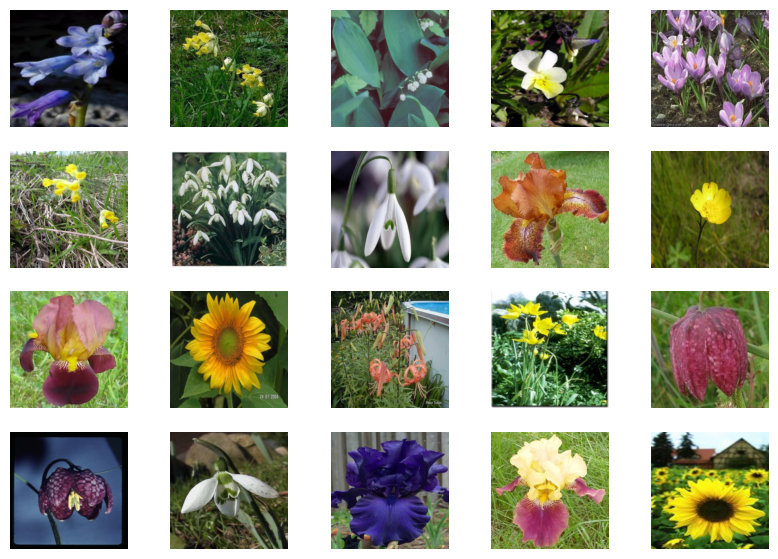

In [20]:
images = iter(dataset)
images = next(images)[0][:20]
images = images.numpy().transpose(0,2,3,1)
plot_multiple_images(images, 4)

## Defining the Auto-Encoder

We'll define the encoder as a series of convolutional layers that learn down-sampled latent representations of images. Instead of using a max or average pooling layer, we'll use a stride of size 2, which allows us to down-sample the image with less information loss.



In [21]:
#Defining our encoder
class Encoder(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 512) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, out_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, imgs: torch.Tensor) -> torch.Tensor:
        latent_z = self.layer1(imgs)
        latent_z = self.layer2(latent_z)
        latent_z = self.layer3(latent_z)
        latent_z = self.layer4(latent_z)
        latent_z = self.layer5(latent_z)
        return latent_z


In [22]:
encoder = Encoder()

The decoder will be a set of deconvolution operators. This operation upsamples starting from the latent space, so at the end the original image could be reconstructed. 

In [23]:
class Decoder(nn.Module):
    def __init__(self, in_channels: int = 512, out_channels: int = 3) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 256, 3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(
                32, out_channels, 3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(out_channels),
            nn.Sigmoid(),
        )

    def forward(self, latent: torch.Tensor) -> torch.Tensor:
        recons = self.layer1(latent)
        recons = self.layer2(recons)
        recons = self.layer3(recons)
        recons = self.layer4(recons)
        recons = self.layer5(recons)
        return recons

In [24]:
decoder = Decoder()

We'll define the ```AutoEncoder``` class as a wrapper to compose the complete architecture for the encoder and decoder networks.

In [25]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
    ) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, imgs: torch.Tensor) -> torch.Tensor:
        latent_z = self.encoder(imgs)
        x_hat = self.decoder(latent_z)
        return x_hat

We check the available hardware to run this model.
For those who don't have access to a GPU, we'll define the autoencoder to consist of just a convolution layer for the encoder and a deconvolution layer for the decoder.

In [26]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
    autoencoder = AutoEncoder(encoder, decoder)
else:
    DEVICE = 'cpu'
    autoencoder = AutoEncoder(encoder.layer1, decoder.layer5)
print(DEVICE)

cuda


## Training our model

Just to have an idea of what the model returns as it is, i.e. without training, check the next images.
As shown below, the model is unable to reproduce its inputs.

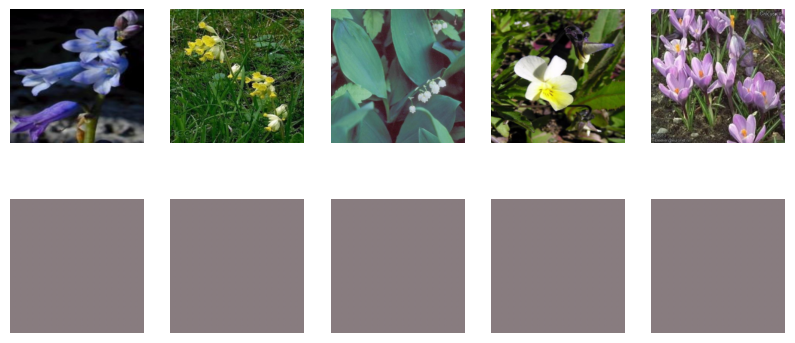

In [27]:
autoencoder.to(DEVICE)

#Sample five images to test
test = torch.from_numpy(images.transpose(0, 3, 1, 2)[:5]).to(DEVICE)
autoencoder.eval()
recons = autoencoder(test)

#plotting reconstructions without training
test_ = test.detach().cpu().numpy().transpose(0, 2, 3, 1)
recons = recons.detach().cpu().numpy().transpose(0, 2, 3, 1)
visualize_intermediate_reconstruction([test_, recons], 3)



We provide the next training routine, which starts with the definition of the loss function, in this case we use the Mean Squared Error (MSE). We also define the optimizer, Stochastic Gradient Descent (SGD). This process iterates over a given number of epochs and does the forward and backward propagations through mini-batches of the data set.

We save a sample of the model reconstructions every 50 epochs for visualization purposes. 

In [14]:
def train(
	model: nn.Module, data: DataLoader, epochs: int = 500
) -> List[float]:
	criterion = nn.MSELoss()
	optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
	losses = []
	recons = []
	model.train()
	for epoch in range(epochs):
		total_loss = 0.0
		for x, _ in data:
			x = x.to(DEVICE)
			optimizer.zero_grad()
			x_hat = model(x)
			loss = criterion(x_hat, x)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		losses.append(total_loss / len(data))
		if epoch % 50 == 0:
			print(f"Epoch {epoch + 1} | Loss: {total_loss / len(data)}")
			model.eval()
			x_hat = model(test)
			recons.append(x_hat.detach().cpu().numpy().transpose(0, 2, 3, 1))
			model.train()
	return losses, recons

To start the training process we run the next cell. The train function takes as input: the autoencoder, the dataset and the number of epochs. We can observe how the Loss function is decreasing through the number of epochs, a good sign that the model is learning to reconstruct the original images. 

In [15]:
losses, recons = train(autoencoder, dataset, 500)

Epoch 1 | Loss: 0.08019719202373479
Epoch 51 | Loss: 0.009354746661375504
Epoch 101 | Loss: 0.007080642934385184
Epoch 151 | Loss: 0.006434285660853257
Epoch 201 | Loss: 0.005929886174665109
Epoch 251 | Loss: 0.005587005597614759
Epoch 301 | Loss: 0.005395698499538608
Epoch 351 | Loss: 0.005156815089788791
Epoch 401 | Loss: 0.004929499832812596
Epoch 451 | Loss: 0.004832413651653238


A standard procedure is to plot the Loss as a function of the Epochs.

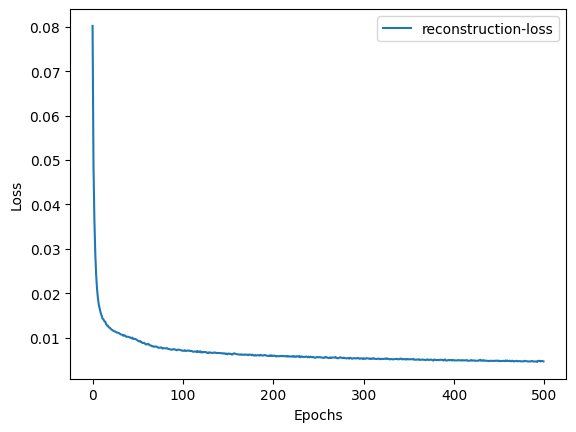

In [16]:
#printing the loss over epochs
plot_loss_history(losses)

We can also see how the reconstructions improved in quality as the loss function was minimized. The images on top are the originals, the second row corresponds to the images at the start of training, and each subsequent row is the model reconstruction after every 50 epochs. Observe that the model achieves a good reconstruction even before the last epochs. 

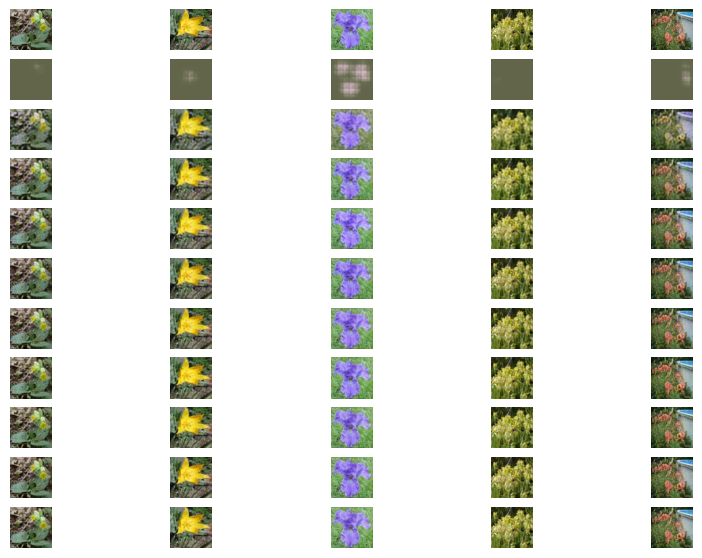

In [17]:
visualize_intermediate_reconstruction([test_] + recons, 11)

## Evaluate our model on unseen data

Finally, we'll evaluate the model reconstructions using previously unseen data (test data).
The validation set of the 17-category flower dataset consist of 170 images, we'll use a subset of this dataset to evaluate the trained model. 

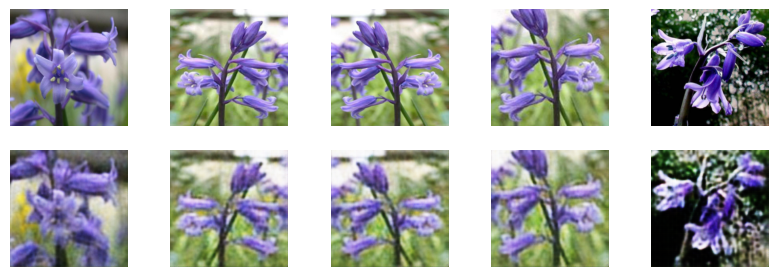

In [19]:
autoencoder.eval()
data = ImageFolder(root='./17_flowers/validation', transform=transforms)
data = DataLoader(data, batch_size=5, num_workers=8, drop_last=True)
data = iter(data)
x, _ = next(data)
eval_recons = autoencoder(x.to(DEVICE))

results = np.vstack([
    x.cpu().numpy()[:10], 
    eval_recons.detach().cpu().numpy()[:10], 
])

results = results.transpose(0, 2, 3, 1)

plot_multiple_images(results, 4)